In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.init as init

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional
import imageio
import dlib
from tqdm import tqdm
import warnings
import cv2
import time

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams["figure.figsize"] = (9, 5)

# --- Configuration ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

FRAME_COUNT = 75
FRAME_HEIGHT = 50
FRAME_WIDTH = 100
FRAME_CHANNELS = 3
DROPOUT_P = 0.5

# --- Kaggle Paths ---
KAGGLE_BASE_PATH = './GRIDCorpus/data/'
# BASE_VIDEO_DIR = os.path.join(KAGGLE_BASE_PATH) # Root for s*_processed folders
# BASE_ALIGN_DIR = os.path.join(KAGGLE_BASE_PATH) # Alignments are inside s*_processed/align

# --- Local Paths (if testing locally, adjust these) ---
# KAGGLE_BASE_PATH = './data/' # Example if 'data' dir is local

# Assuming speaker IDs 1-34, excluding 21
# Reduced speaker list for faster testing initially - ADJUST AS NEEDED
# ALL_SPEAKER_IDS = [f's{i}' for i in range(1, 3) if i != 21] # Example: Use only s1, s2
ALL_SPEAKER_IDS = [f's{i}' for i in range(1, 3) if i != 21] # Full speaker list

# --- Split Configuration ---
TEST_SPEAKERS_UNSEEN = ['s1', 's2'] # Adjust if needed based on speakers used
NUM_TEST_SENTENCES_OVERLAPPED = 200
SPLIT_MODE = 'overlapped' # Choose 'unseen' or 'overlapped'

# Normalization constants
NORM_MEAN = np.array([0.7136, 0.4906, 0.3283], dtype=np.float32)
NORM_STD = np.array([0.1138, 0.1078, 0.0917], dtype=np.float32)

# --- Vocabulary ---
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz "]
char_to_num_dict = {char: i + 1 for i, char in enumerate(vocab)} # Start indices from 1
num_to_char_dict = {i + 1: char for i, char in enumerate(vocab)}
VOCAB_SIZE = len(vocab)
CTC_BLANK_INDEX = 0
LABEL_PADDING_VALUE = CTC_BLANK_INDEX

print(f"The vocabulary is: {vocab} (size ={VOCAB_SIZE})")
print(f"CTC Blank Index: {CTC_BLANK_INDEX}")
print(f"Label Padding Value: {LABEL_PADDING_VALUE}")

# --- Mouth Extraction (dlib setup) ---
try:
    # Try loading from Kaggle input first, then local
    DLIB_PREDICTOR_PATHS = [
        "shape_predictor_68_face_landmarks.dat"
    ]
    DLIB_LANDMARK_PREDICTOR = None
    for path in DLIB_PREDICTOR_PATHS:
        if os.path.exists(path):
            DLIB_LANDMARK_PREDICTOR = path
            break
    if DLIB_LANDMARK_PREDICTOR is None:
        raise FileNotFoundError("dlib landmark predictor not found.")

    print(f"Using dlib predictor: {DLIB_LANDMARK_PREDICTOR}")
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(DLIB_LANDMARK_PREDICTOR)
except Exception as e:
    print(f"Error initializing dlib: {e}")
    print("Make sure dlib is installed and the predictor file exists (shape_predictor_68_face_landmarks.dat).")
    exit()

def extract_mouth_region(frame: np.ndarray) -> Optional[np.ndarray]:
    # (Keep the function from previous version - it operates on a single frame)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return None
    face = faces[0]
    landmarks = predictor(gray, face)
    points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])

    x, y, w, h = cv2.boundingRect(points)
    # Adjust margins carefully - trying to match TF code's effective crop
    y_start = max(y + 15 - 30, 0)
    y_end = y + 15 + h + 30
    x_start = max(x + 15 - 30, 0)
    x_end = x + 15 + w + 30

    y_start = max(0, y_start)
    y_end = min(frame.shape[0], y_end)
    x_start = max(0, x_start)
    x_end = min(frame.shape[1], x_end)

    cropped = frame[y_start:y_end, x_start:x_end]

    if cropped.size == 0:
        return np.zeros((FRAME_HEIGHT, FRAME_WIDTH, 3), dtype=np.uint8)
    try:
        cropped = cv2.resize(cropped, (FRAME_WIDTH, FRAME_HEIGHT))
        return cropped
    except cv2.error as e:
        print(f"Warning: cv2.resize error ({e}). Returning zero frame.")
        return np.zeros((FRAME_HEIGHT, FRAME_WIDTH, 3), dtype=np.uint8)

# --- Alignment Loading (Needs correct path derivation) ---
def get_align_path(video_path):
    """Derives the alignment file path from the video path for Kaggle structure."""
    parts = video_path.split(os.path.sep)
    video_filename = parts[-1]
    speaker_processed_dir = parts[-2] # e.g., 's1_processed'
    base_name = os.path.splitext(video_filename)[0]
    # Construct align path relative to the input directory base
    align_dir = os.path.join(KAGGLE_BASE_PATH, speaker_processed_dir, 'align')
    return os.path.join(align_dir, f'{base_name}.align')

def load_alignments(align_file: str) -> Optional[List[str]]:
    # (Keep function from previous version, path is handled outside now)
    alignments_chars = []
    try:
        with open(align_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 3:
                    continue
                _, _, token = parts
                if token != 'sil':
                    token_characters = list(token.lower() + ' ')
                    alignments_chars.extend(token_characters)
        return alignments_chars[:-1] if alignments_chars else []
    except FileNotFoundError:
         # print(f"Warning: Alignment file not found: {align_file}") # Less noisy
         return None
    except Exception as e:
        print(f"Error loading alignments {align_file}: {e}")
        return None

# --- File Listing and Splitting ---
all_video_files = []
print("Searching for video files...")
# Search for common video formats within s*_processed directories
for speaker_id_num in range(1, 3): # Check all potential speaker numbers
    if speaker_id_num == 21: continue # Skip speaker 21
    speaker_processed_folder = f"s{speaker_id_num}_processed"
    speaker_path_pattern = os.path.join(KAGGLE_BASE_PATH, speaker_processed_folder, '*.mpg') # Check mpg first
    files = glob.glob(speaker_path_pattern)
    if not files:
        speaker_path_pattern = os.path.join(KAGGLE_BASE_PATH, speaker_processed_folder, '*.mp4') # Check mp4
        files = glob.glob(speaker_path_pattern)

    if not files:
        print(f"Warning: No .mpg or .mp4 files found for speaker {speaker_id_num} in {os.path.join(KAGGLE_BASE_PATH, speaker_processed_folder)}")
    else:
        print(f"Found {len(files)} files for speaker {speaker_id_num}")
    all_video_files.extend(files)


if not all_video_files:
    raise FileNotFoundError(f"No video files (.mpg or .mp4) found in subdirectories like {os.path.join(KAGGLE_BASE_PATH, 's*_processed/')}. Please check KAGGLE_BASE_PATH and dataset structure.")

np.random.seed(SEED)
np.random.shuffle(all_video_files)
train_files, test_files = [], []

# --- Splitting Logic (based on video paths now) ---
if SPLIT_MODE == 'unseen':
    print(f"Using unseen speakers split. Test speakers: {TEST_SPEAKERS_UNSEEN}")
    for f in all_video_files:
        speaker_id = os.path.basename(os.path.dirname(f)).split('_')[0] # Extract 'sX' from 'sX_processed'
        if speaker_id in TEST_SPEAKERS_UNSEEN:
            test_files.append(f)
        else:
            train_files.append(f)
elif SPLIT_MODE == 'overlapped':
    print(f"Using overlapped speakers split. {NUM_TEST_SENTENCES_OVERLAPPED} test sentences per speaker.")
    files_by_speaker = {}
    for f in all_video_files:
        speaker_id = os.path.basename(os.path.dirname(f)).split('_')[0]
        if speaker_id not in files_by_speaker:
            files_by_speaker[speaker_id] = []
        files_by_speaker[speaker_id].append(f)

    for speaker_id, files in files_by_speaker.items():
        np.random.shuffle(files)
        test_count = min(NUM_TEST_SENTENCES_OVERLAPPED, len(files))
        test_files.extend(files[:test_count])
        train_files.extend(files[test_count:])
else:
    raise ValueError("Invalid SPLIT_MODE. Choose 'unseen' or 'overlapped'.")

print(f"Total video files found: {len(all_video_files)}")
print(f"Training files: {len(train_files)}")
print(f"Test files: {len(test_files)}")

if not train_files or not test_files:
    raise ValueError("Training or test set is empty. Check file paths and splitting logic.")

Using device: cpu
The vocabulary is: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' '] (size =27)
CTC Blank Index: 0
Label Padding Value: 0
Using dlib predictor: shape_predictor_68_face_landmarks.dat
Searching for video files...
Found 1000 files for speaker 1
Found 1000 files for speaker 2
Using overlapped speakers split. 200 test sentences per speaker.
Total video files found: 2000
Training files: 1600
Test files: 400


In [ ]:
# --- PyTorch Dataset (On-the-fly Preprocessing) ---
class GRIDDataset(Dataset):
    def __init__(self, file_paths: List[str], augment: bool = False):
        self.file_paths = file_paths
        self.augment = augment
        self.target_frame_count = FRAME_COUNT

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        video_path = self.file_paths[idx]
        try:
            # --- Load Original Video ---
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Warning: Could not open video {video_path}. Skipping.")
                raise IOError("Could not open video")

            extracted_mouth_frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                mouth_crop = extract_mouth_region(frame) # Returns uint8 BGR
                if mouth_crop is None:
                     # Use a black frame if detection fails
                     mouth_crop = np.zeros((FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS), dtype=np.uint8)
                extracted_mouth_frames.append(mouth_crop)
            cap.release()

            if not extracted_mouth_frames:
                 print(f"Warning: No frames extracted from {video_path}. Skipping.")
                 raise ValueError("No frames extracted")

            # --- Pad/Truncate Frames ---
            frames_np_uint8 = np.stack(extracted_mouth_frames)
            current_frame_count = frames_np_uint8.shape[0]

            if current_frame_count != self.target_frame_count:
                if current_frame_count > self.target_frame_count:
                    frames_np_uint8 = frames_np_uint8[:self.target_frame_count, ...]
                else:
                    pad_width = ((0, self.target_frame_count - current_frame_count), (0, 0), (0, 0), (0, 0))
                    frames_np_uint8 = np.pad(frames_np_uint8, pad_width, mode='constant', constant_values=0)

            # --- Convert, Normalize, BGR->RGB ---
            frames_float = frames_np_uint8.astype(np.float32) / 255.0
            frames_rgb = frames_float[..., ::-1]
            frames_normalized = (frames_rgb - NORM_MEAN) / NORM_STD
            frames_tensor = torch.tensor(frames_normalized, dtype=torch.float32)

            # --- Get Alignments ---
            align_path = get_align_path(video_path)
            alignments_list = load_alignments(align_path)
            if alignments_list is None:
                print(f"Skipping {video_path} due to missing alignment {align_path}.")
                raise ValueError("Missing alignment")

            label_indices = [char_to_num_dict.get(char, CTC_BLANK_INDEX) for char in alignments_list]
            label_tensor = torch.tensor(label_indices, dtype=torch.long)

            # --- Augmentation ---
            if self.augment and torch.rand(1).item() > 0.5:
                frames_tensor = torch.flip(frames_tensor, dims=[2]) # Flip width

            return frames_tensor, label_tensor

        except Exception as e:
            print(f"Error processing item {idx} ({video_path}): {e}")
            # Return dummy data that collate_fn can filter
            return torch.zeros((FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS), dtype=torch.float32), \
                   torch.tensor([], dtype=torch.long)


# --- Collate Function (Remains the same) ---
def collate_fn(batch):
    batch = [(frames, labels) for frames, labels in batch if frames is not None and labels.numel() > 0]
    if not batch:
        return torch.tensor([]), torch.tensor([]), torch.tensor([]), torch.tensor([])

    frames_list, labels_list = zip(*batch)
    frames_batch = torch.stack(frames_list, dim=0)
    label_lengths = torch.tensor([len(lbl) for lbl in labels_list], dtype=torch.long)
    labels_padded = pad_sequence(labels_list, batch_first=True, padding_value=LABEL_PADDING_VALUE)
    input_lengths = torch.full(size=(len(batch),), fill_value=FRAME_COUNT, dtype=torch.long)
    return frames_batch, labels_padded, input_lengths, label_lengths


# --- Data Loaders ---
BATCH_SIZE_TRAIN = 32 # Adjust based on Kaggle GPU memory (T4/P100)
BATCH_SIZE_TEST = 32
NUM_WORKERS = 2 # Use multiple workers on Kaggle

train_dataset = GRIDDataset(train_files, augment=True)
test_dataset = GRIDDataset(test_files, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True,
                          collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=True,
                          persistent_workers=(NUM_WORKERS > 0)) # Add persistent_workers
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False,
                         collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=True,
                         persistent_workers=(NUM_WORKERS > 0)) # Add persistent_workers

print("DataLoaders created.")


# --- PyTorch LipNet Model (Remains the same as previous version) ---
class LipNet(nn.Module):
    def __init__(self, num_classes, dropout_p=DROPOUT_P):
        super(LipNet, self).__init__()
        self.num_classes = num_classes # Should include blank token
        self.dropout_p = dropout_p

        # Spatiotemporal Convolutional Layers (STCNN)
        self.conv1 = nn.Conv3d(FRAME_CHANNELS, 32, kernel_size=(3, 5, 5), stride=(1, 2, 2), padding=(1, 2, 2))
        self.bn1 = nn.BatchNorm3d(32)
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.drop1 = nn.Dropout3d(dropout_p)

        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 5, 5), stride=(1, 1, 1), padding=(1, 2, 2))
        self.bn2 = nn.BatchNorm3d(64)
        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.drop2 = nn.Dropout3d(dropout_p)

        self.conv3 = nn.Conv3d(64, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.bn3 = nn.BatchNorm3d(96)
        self.pool3 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.drop3 = nn.Dropout3d(dropout_p)

        self.rnn_input_size = 96 * 3 * 6

        # Bidirectional GRU Layers
        self.gru1 = nn.GRU(self.rnn_input_size, 256, bidirectional=True, batch_first=True)
        self.drop_gru1 = nn.Dropout(dropout_p)
        self.gru2 = nn.GRU(256 * 2, 256, bidirectional=True, batch_first=True)
        self.drop_gru2 = nn.Dropout(dropout_p)

        # Fully Connected Layer
        self.fc = nn.Linear(256 * 2, self.num_classes)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None: init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d): init.constant_(m.weight, 1); init.constant_(m.bias, 0)
            elif isinstance(m, nn.GRU):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name: init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name: init.orthogonal_(param.data)
                    elif 'bias' in name: init.constant_(param.data, 0)
            elif isinstance(m, nn.Linear): init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu'); init.constant_(m.bias, 0)

    def forward(self, x):
        # Input shape: (N, T, H, W, C)
        x = x.permute(0, 4, 1, 2, 3).contiguous() # -> (N, C, T, H, W)
        x = self.conv1(x); x = self.bn1(x); x = F.relu(x); x = self.pool1(x); x = self.drop1(x)
        x = self.conv2(x); x = self.bn2(x); x = F.relu(x); x = self.pool2(x); x = self.drop2(x)
        x = self.conv3(x); x = self.bn3(x); x = F.relu(x); x = self.pool3(x); x = self.drop3(x)
        N, C, T, H, W = x.size()
        x = x.permute(0, 2, 1, 3, 4).contiguous() # -> (N, T, C, H, W)
        x = x.view(N, T, -1) # -> (N, T, C*H*W)
        x, _ = self.gru1(x); x = self.drop_gru1(x)
        x, _ = self.gru2(x); x = self.drop_gru2(x) # -> (N, T, hidden*2)
        x = self.fc(x) # -> (N, T, num_classes)
        x = x.permute(1, 0, 2).contiguous() # -> (T, N, C) for CTC
        log_probs = F.log_softmax(x, dim=2)
        return log_probs

# --- Instantiate Model, Loss, Optimizer (Remain the same) ---
model = LipNet(num_classes=VOCAB_SIZE + 1).to(DEVICE)
ctc_loss = nn.CTCLoss(blank=CTC_BLANK_INDEX, reduction='mean', zero_infinity=True)
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)

# --- Checkpoint Path (Use Kaggle working directory) ---
checkpoint_dir = './models_pytorch/main2_Copy/'
checkpoint_path = os.path.join(checkpoint_dir, 'lipnet_checkpoint.pth')
os.makedirs(checkpoint_dir, exist_ok=True)

# --- Greedy Decoder & ProduceExample (Remain the same) ---
def greedy_decoder(log_probs, input_lengths):
    # (Keep function from previous version)
    decoded_sequences = []
    for i in range(log_probs.size(1)):
        sample_log_probs = log_probs[:input_lengths[i], i, :]
        best_path = torch.argmax(sample_log_probs, dim=1)
        decoded = []
        last_char = -1
        for char_idx in best_path:
            idx = char_idx.item()
            if idx != last_char and idx != CTC_BLANK_INDEX:
                decoded.append(idx)
            if idx != CTC_BLANK_INDEX:
                last_char = idx
        decoded_sequences.append(decoded)
    return decoded_sequences

def produce_example(model, dataset_loader, num_to_char_map):
    # (Keep function from previous version)
    model.eval()
    with torch.no_grad():
        try:
            frames_batch, labels_batch, input_lengths, label_lengths = next(iter(dataset_loader))
            frames_batch = frames_batch.to(DEVICE)
            log_probs = model(frames_batch)
            log_probs_cpu = log_probs.cpu()
            input_lengths_cpu = input_lengths.cpu()
            decoded_indices_list = greedy_decoder(log_probs_cpu, input_lengths_cpu)
            print("\n--- Example Predictions ---")
            N_EXAMPLES_TO_SHOW = min(2, frames_batch.size(0))
            for i in range(N_EXAMPLES_TO_SHOW):
                original_indices = labels_batch[i][:label_lengths[i]].tolist()
                original_text = "".join([num_to_char_map.get(idx, '?') for idx in original_indices])
                print(f'Original:     {original_text}')
                prediction_indices = decoded_indices_list[i]
                print(f'Filtered Idx: {prediction_indices}')
                prediction_text = "".join([num_to_char_map.get(idx, '?') for idx in prediction_indices])
                print(f'Prediction:   {prediction_text}')
                print('-'*50)
            print("--- End Examples ---\n")
        except StopIteration: print("Warning: Could not get batch for ProduceExample.")
        except Exception as e: print(f"Error during ProduceExample: {e}")
    model.train()

# --- Training Loop (Remains largely the same, ensure data paths are correct) ---
EPOCHS = 50
best_val_loss = float('inf')
train_losses = []
val_losses = []

start_epoch = 0
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    try:
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['loss']
        # Load scheduler state if available
        if 'scheduler_state_dict' in checkpoint:
             scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print(f"Resuming training from epoch {start_epoch}, Best loss: {best_val_loss:.4f}")
    except Exception as e:
        print(f"Error loading checkpoint: {e}. Starting from scratch.")
        start_epoch = 0
        best_val_loss = float('inf')

print("\nStarting Training...")
# Estimate batches if needed (DataLoader length should work)
try:
    num_train_batches = len(train_loader)
    num_test_batches = len(test_loader)
except TypeError: # Handle cases where len() isn't directly supported
    print("Could not determine DataLoader length directly, estimating batches.")
    num_train_batches = len(train_files) // BATCH_SIZE_TRAIN
    num_test_batches = len(test_files) // BATCH_SIZE_TEST


print(f"Training batches per epoch: {num_train_batches}")
print(f"Validation batches per epoch: {num_test_batches}")

for epoch in range(start_epoch, EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    model.train()
    running_loss = 0.0
    train_pbar = tqdm(enumerate(train_loader), total=num_train_batches, desc=f"Epoch {epoch+1} Train")

    for i, batch_data in train_pbar:
        # Ensure batch is not empty (can happen if all samples failed in collate)
        if batch_data[0].numel() == 0:
             print(f"Warning: Skipping empty batch at step {i}")
             continue

        frames_batch, labels_padded, input_lengths, label_lengths = batch_data
        frames_batch = frames_batch.to(DEVICE)
        labels_padded = labels_padded.to(DEVICE)
        input_lengths = input_lengths.to(DEVICE)
        label_lengths = label_lengths.to(DEVICE)

        optimizer.zero_grad()
        log_probs = model(frames_batch) # T, N, C
        T = log_probs.size(0)
        input_lengths_clamped = torch.clamp(input_lengths, max=T).cpu() # Ensure lengths are on CPU for loss
        label_lengths_cpu = label_lengths.cpu()
        labels_padded_cpu = labels_padded.cpu()

        loss = ctc_loss(log_probs.cpu(), labels_padded_cpu, input_lengths_clamped, label_lengths_cpu)

        if torch.isnan(loss) or torch.isinf(loss):
             print(f"\nWarning: NaN or Inf loss detected at batch {i}. Skipping batch.")
             continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
        optimizer.step()

        running_loss += loss.item()
        train_pbar.set_postfix({'loss': running_loss / (i + 1)})

    avg_train_loss = running_loss / num_train_batches if num_train_batches > 0 else 0
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

    # --- Validation ---
    model.eval()
    running_val_loss = 0.0
    val_pbar = tqdm(enumerate(test_loader), total=num_test_batches, desc=f"Epoch {epoch+1} Val")
    with torch.no_grad():
        for i, batch_data in val_pbar:
            if batch_data[0].numel() == 0: continue # Skip empty batch

            frames_batch, labels_padded, input_lengths, label_lengths = batch_data
            frames_batch = frames_batch.to(DEVICE)
            labels_padded = labels_padded.to(DEVICE)
            input_lengths = input_lengths.to(DEVICE)
            label_lengths = label_lengths.to(DEVICE)

            log_probs = model(frames_batch)
            T = log_probs.size(0)
            input_lengths_clamped = torch.clamp(input_lengths, max=T).cpu()
            label_lengths_cpu = label_lengths.cpu()
            labels_padded_cpu = labels_padded.cpu()

            loss = ctc_loss(log_probs.cpu(), labels_padded_cpu, input_lengths_clamped, label_lengths_cpu)

            if not (torch.isnan(loss) or torch.isinf(loss)):
                running_val_loss += loss.item()
            val_pbar.set_postfix({'val_loss': running_val_loss / (i + 1)})

    avg_val_loss = running_val_loss / num_test_batches if num_test_batches > 0 else 0
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")
    scheduler.step(avg_val_loss) # Step the scheduler

    # --- Save Checkpoint ---
    if avg_val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}, saving model to {checkpoint_path}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(), # Save scheduler state
            'loss': avg_val_loss,
            'train_losses': train_losses, # Save history
            'val_losses': val_losses,     # Save history
        }, checkpoint_path)
        best_val_loss = avg_val_loss
    else:
        print(f"Validation loss ({avg_val_loss:.4f}) did not improve from {best_val_loss:.4f}")

    # --- Show Examples periodically ---
    if (epoch + 1) % 5 == 0 or epoch == EPOCHS - 1:
         produce_example(model, test_loader, num_to_char_dict)

print("\nTraining Finished.")

# --- Plotting (Remains the same) ---
plt.figure(figsize=(8, 3))
plt.plot(range(1, len(train_losses) + 1), train_losses, color='red', label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, color='green', label="Validation Loss")
plt.title("Training/Validation Loss vs Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/kaggle/working/loss_curve_pytorch.png") # Save to working dir
plt.show()

# --- Final Testing Example (Remains the same) ---
print("\n--- Running Final Test Examples ---")
if os.path.exists(checkpoint_path):
    print(f"Loading best weights from {checkpoint_path} for final test...")
    try:
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Best weights loaded successfully.")
        produce_example(model, test_loader, num_to_char_dict)
    except Exception as e: print(f"Error loading best weights: {e}")
else: print("No checkpoint found for final testing.")
print("--- Final Testing Finished ---")

In [6]:
# --- Mouth Extraction (Mostly unchanged, ensure return type is numpy) ---
try:
    DLIB_LANDMARK_PREDICTOR = "shape_predictor_68_face_landmarks.dat"
    if not os.path.exists(DLIB_LANDMARK_PREDICTOR):
        # Add download/unzip logic here if needed, e.g., using requests/bz2
        print(f"Error: dlib landmark predictor '{DLIB_LANDMARK_PREDICTOR}' not found.")
        print("Please download it from http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2")
        exit()
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(DLIB_LANDMARK_PREDICTOR)
except Exception as e:
    print(f"Error initializing dlib: {e}")
    print("Make sure dlib is installed correctly and the predictor file exists.")
    exit()

def extract_mouth_region(frame: np.ndarray) -> Optional[np.ndarray]:
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return None
    face = faces[0]
    landmarks = predictor(gray, face)
    points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])

    x, y, w, h = cv2.boundingRect(points)
    # Adjust margins carefully - TF code used slightly different logic
    # Let's try to match the TF code's effective crop:
    y_start = max(y + 15 - 30, 0) # y + 15 was start, margin was 30
    y_end = y + 15 + h + 30
    x_start = max(x + 15 - 30, 0) # x + 15 was start, margin was 30
    x_end = x + 15 + w + 30

    # Ensure coordinates are within frame bounds
    y_start = max(0, y_start)
    y_end = min(frame.shape[0], y_end)
    x_start = max(0, x_start)
    x_end = min(frame.shape[1], x_end)

    cropped = frame[y_start:y_end, x_start:x_end]

    if cropped.size == 0: # Handle empty crop
        return np.zeros((FRAME_HEIGHT, FRAME_WIDTH, 3), dtype=np.uint8)

    try:
        cropped = cv2.resize(cropped, (FRAME_WIDTH, FRAME_HEIGHT))
        return cropped
    except cv2.error as e:
        print(f"Warning: cv2.resize error ({e}). Returning zero frame.")
        return np.zeros((FRAME_HEIGHT, FRAME_WIDTH, 3), dtype=np.uint8)

def process_and_save_video(video_path: str, output_dir: str) -> None:
    """Processes a single video, extracts mouth regions, and saves as .npy"""
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error opening video file: {video_path}")
            return None
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            mouth_frame = extract_mouth_region(frame)
            if mouth_frame is not None:
                frames.append(mouth_frame)
            else:
                # If detection fails, append a zero frame
                frames.append(np.zeros((FRAME_HEIGHT, FRAME_WIDTH, 3), dtype=np.uint8))
        cap.release()

        if not frames:
            print(f"Warning: No frames extracted from {video_path}")
            return None

        # Ensure video has FRAME_COUNT frames (pad/truncate if needed)
        frames_np = np.array(frames, dtype=np.uint8) # Keep as uint8 for now
        current_frame_count = frames_np.shape[0]
        if current_frame_count != FRAME_COUNT:
             if current_frame_count > FRAME_COUNT:
                 frames_np = frames_np[:FRAME_COUNT, ...]
             else:
                 pad_width = ((0, FRAME_COUNT - current_frame_count), (0, 0), (0, 0), (0, 0))
                 frames_np = np.pad(frames_np, pad_width, mode='constant', constant_values=0)

        video_id = os.path.splitext(os.path.basename(video_path))[0]
        output_path = os.path.join(output_dir, f"{video_id}_mouth.npy")
        np.save(output_path, frames_np)

    except Exception as e:
        print(f"Error processing video {video_path}: {e}")
    return None


# --- Function to preprocess all videos (Run only once) ---
def preprocess_all_videos(force_reprocess=False):
    print("Starting video preprocessing...")
    processed_count = 0
    skipped_count = 0
    for speaker_id in ALL_SPEAKER_IDS:
        input_videos_dir = os.path.join('./data/', speaker_id, 'video') # Assuming video folder structure
        output_preprocessed_dir = os.path.join(BASE_PROCESSED_PATH, speaker_id)
        os.makedirs(output_preprocessed_dir, exist_ok=True)

        print(f"Processing speaker: {speaker_id}")
        video_files = glob.glob(os.path.join(input_videos_dir, '*.mpg')) # Assuming .mpg format

        if not video_files:
             print(f"  Warning: No .mpg files found in {input_videos_dir}")
             continue

        for video_file in tqdm(video_files, desc=f"Speaker {speaker_id}", unit="video"):
             video_id = os.path.splitext(os.path.basename(video_file))[0]
             output_path = os.path.join(output_preprocessed_dir, f"{video_id}_mouth.npy")
             if not force_reprocess and os.path.exists(output_path):
                 skipped_count += 1
                 continue
             process_and_save_video(video_file, output_preprocessed_dir)
             processed_count += 1

    print(f"\nPreprocessing finished. Processed: {processed_count}, Skipped (already exists): {skipped_count}")

# --- UNCOMMENT AND RUN THIS ONCE TO PREPROCESS ---
# preprocess_all_videos(force_reprocess=False)
# print("Preprocessing complete. You can now comment out the preprocess_all_videos call.")
# --- END PREPROCESSING CALL ---

In [7]:
# --- GIF Creation (Unchanged) ---
def create_gif_from_npy(npy_path: str, gif_path: str, duration: float = 0.04) -> None:
    try:
        frames = np.load(npy_path) # Should be uint8
        imageio.mimsave(gif_path, frames, duration=duration)
    except FileNotFoundError:
        print(f"Warning: Npy file not found at {npy_path}, cannot create GIF.")
    except Exception as e:
        print(f"Error creating GIF from {npy_path}: {e}")
    return None

In [8]:
# --- Alignment Loading (Unchanged, returns list of chars) ---
def load_alignments(align_file: str) -> Optional[List[str]]:
    alignments_chars = []
    try:
        with open(align_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 3:
                    continue
                _, _, token = parts
                if token != 'sil':
                    token_characters = list(token.lower() + ' ')
                    alignments_chars.extend(token_characters)
        # Remove the trailing space from the last word
        return alignments_chars[:-1] if alignments_chars else []
    except FileNotFoundError:
         print(f"Warning: Alignment file not found: {align_file}")
         return None
    except Exception as e:
        print(f"Error loading alignments {align_file}: {e}")
        return None

In [9]:
example_alignment = load_alignments("./data/alignments/s1/lrwz4p.align")
print(example_alignment)

['l', 'a', 'y', ' ', 'r', 'e', 'd', ' ', 'w', 'i', 't', 'h', ' ', 'z', ' ', 'f', 'o', 'u', 'r', ' ', 'p', 'l', 'e', 'a', 's', 'e']


In [10]:
# --- File Listing and Splitting ---
all_npy_files = []
for speaker_id in ALL_SPEAKER_IDS:
    speaker_path = os.path.join(BASE_PROCESSED_PATH, speaker_id, '*.npy')
    files = glob.glob(speaker_path)
    if not files:
        print(f"Warning: No .npy files found for speaker {speaker_id} in {os.path.join(BASE_PROCESSED_PATH, speaker_id)}")
    all_npy_files.extend(files)

if not all_npy_files:
    raise FileNotFoundError(f"No .npy files found in {BASE_PROCESSED_PATH} for speakers {ALL_SPEAKER_IDS}. Did preprocessing run?")

np.random.shuffle(all_npy_files)
train_files, test_files = [], []

if SPLIT_MODE == 'unseen':
    print(f"Using unseen speakers split. Test speakers: {TEST_SPEAKERS_UNSEEN}")
    for f in all_npy_files:
        speaker_id = os.path.basename(os.path.dirname(f))
        if speaker_id in TEST_SPEAKERS_UNSEEN:
            test_files.append(f)
        else:
            train_files.append(f)
elif SPLIT_MODE == 'overlapped':
    print(f"Using overlapped speakers split. {NUM_TEST_SENTENCES_OVERLAPPED} test sentences per speaker.")
    files_by_speaker = {}
    for f in all_npy_files:
        speaker_id = os.path.basename(os.path.dirname(f))
        if speaker_id not in files_by_speaker:
            files_by_speaker[speaker_id] = []
        files_by_speaker[speaker_id].append(f)

    for speaker_id, files in files_by_speaker.items():
        np.random.shuffle(files)
        test_count = min(NUM_TEST_SENTENCES_OVERLAPPED, len(files))
        test_files.extend(files[:test_count])
        train_files.extend(files[test_count:])
else:
    raise ValueError("Invalid SPLIT_MODE. Choose 'unseen' or 'overlapped'.")

print(f"Total files found: {len(all_npy_files)}")
print(f"Training files: {len(train_files)}")
print(f"Test files: {len(test_files)}")

if not train_files or not test_files:
    raise ValueError("Training or test set is empty. Check file paths and splitting logic.")

Using overlapped speakers split. 200 test sentences per speaker.
Total files found: 995
Training files: 795
Test files: 200


In [11]:
# --- PyTorch Dataset ---
class GRIDDataset(Dataset):
    def __init__(self, file_paths: List[str], augment: bool = False):
        self.file_paths = file_paths
        self.augment = augment
        self.target_frame_count = FRAME_COUNT # Define target length

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        npy_path = self.file_paths[idx]
        try:
            # --- Load Frames (Keep as uint8 for now) ---
            # This part loads the preprocessed mouth crops saved earlier
            frames_uint8 = np.load(npy_path)

            if frames_uint8.ndim != 4 or frames_uint8.shape[1:] != (FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS):
                 print(f"Warning: Unexpected shape {frames_uint8.shape} for {npy_path}. Skipping.")
                 # Return dummy data that collate_fn can handle/filter
                 return torch.zeros((FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS), dtype=torch.float32), \
                        torch.tensor([], dtype=torch.long)

            # --- Ensure Correct Frame Count ---
            current_frame_count = frames_uint8.shape[0]
            if current_frame_count != self.target_frame_count:
                if current_frame_count > self.target_frame_count:
                    # Truncate
                    frames_uint8 = frames_uint8[:self.target_frame_count, ...]
                else:
                    # Pad with zeros
                    pad_width = ((0, self.target_frame_count - current_frame_count), (0, 0), (0, 0), (0, 0))
                    # Ensure padding uses the correct dtype (uint8) before conversion
                    frames_uint8 = np.pad(frames_uint8, pad_width, mode='constant', constant_values=0)

            # --- Convert to Float, Normalize, Convert BGR->RGB ---
            frames_float = frames_uint8.astype(np.float32) / 255.0
            frames_rgb = frames_float[..., ::-1] # BGR to RGB
            frames_normalized = (frames_rgb - NORM_MEAN) / NORM_STD
            frames_tensor = torch.tensor(frames_normalized, dtype=torch.float32)
            # Shape should now be guaranteed [75, 50, 100, 3]

            # --- Get Alignments ---
            # (Rest of your alignment loading logic remains the same)
            parts = npy_path.split(os.path.sep)
            speaker_id = parts[-2]
            base_name = os.path.splitext(parts[-1])[0]
            if base_name.endswith('_mouth'):
                base_name = base_name[:-6]
            align_file = os.path.join(BASE_ALIGN_PATH, speaker_id, f'{base_name}.align')
            alignments_list = load_alignments(align_file)

            if alignments_list is None:
                print(f"Skipping {npy_path} due to missing alignment.")
                return torch.zeros((FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS), dtype=torch.float32), \
                       torch.tensor([], dtype=torch.long)

            label_indices = [char_to_num_dict.get(char, CTC_BLANK_INDEX) for char in alignments_list] # Use blank for OOV
            label_tensor = torch.tensor(label_indices, dtype=torch.long)

            # --- Augmentation (Applied AFTER ensuring correct shape and normalization) ---
            if self.augment and torch.rand(1).item() > 0.5:
                frames_tensor = torch.flip(frames_tensor, dims=[2]) # Flip width dimension

            return frames_tensor, label_tensor

        except FileNotFoundError:
            print(f"Warning: File not found {npy_path}. Skipping.")
            return torch.zeros((FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS), dtype=torch.float32), \
                   torch.tensor([], dtype=torch.long)
        except Exception as e:
            print(f"Error loading item {idx} ({npy_path}): {e}")
            return torch.zeros((FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS), dtype=torch.float32), \
                   torch.tensor([], dtype=torch.long)

In [12]:
# --- Collate Function ---
def collate_fn(batch):
    # Filter out samples where loading failed (indicated by empty label tensor)
    batch = [(frames, labels) for frames, labels in batch if labels.numel() > 0]
    if not batch:
        # Return empty tensors if the whole batch failed
        return torch.tensor([]), torch.tensor([]), torch.tensor([]), torch.tensor([])

    # Separate frames and labels
    frames_list, labels_list = zip(*batch)

    # Stack frames (already same size T, H, W, C)
    frames_batch = torch.stack(frames_list, dim=0)

    # Pad labels
    label_lengths = torch.tensor([len(lbl) for lbl in labels_list], dtype=torch.long)
    labels_padded = pad_sequence(labels_list, batch_first=True, padding_value=LABEL_PADDING_VALUE)

    # Input lengths for CTC (fixed frame count here)
    input_lengths = torch.full(size=(len(batch),), fill_value=FRAME_COUNT, dtype=torch.long)

    return frames_batch, labels_padded, input_lengths, label_lengths

In [13]:
# --- Data Loaders ---
BATCH_SIZE_TRAIN = 32 # Adjust based on GPU memory
BATCH_SIZE_TEST = 32

train_dataset = GRIDDataset(train_files, augment=True)
test_dataset = GRIDDataset(test_files, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True,
                          collate_fn=collate_fn, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False,
                         collate_fn=collate_fn, num_workers=4, pin_memory=True)

print("DataLoaders created.")
# Optional: Test one batch
try:
    d_frames, d_labels, d_in_len, d_lbl_len = next(iter(train_loader))
    print("Train Batch Shapes:", d_frames.shape, d_labels.shape, d_in_len.shape, d_lbl_len.shape)
    d_frames, d_labels, d_in_len, d_lbl_len = next(iter(test_loader))
    print("Test Batch Shapes:", d_frames.shape, d_labels.shape, d_in_len.shape, d_lbl_len.shape)
except Exception as e:
     print(f"Error fetching batch: {e}")


DataLoaders created.
Train Batch Shapes: torch.Size([32, 75, 50, 100, 3]) torch.Size([32, 28]) torch.Size([32]) torch.Size([32])
Test Batch Shapes: torch.Size([32, 75, 50, 100, 3]) torch.Size([32, 30]) torch.Size([32]) torch.Size([32])


In [16]:
# --- PyTorch LipNet Model ---
class LipNet(nn.Module):
    def __init__(self, num_classes, dropout_p=DROPOUT_P):
        super(LipNet, self).__init__()
        self.num_classes = num_classes # Should include blank token
        self.dropout_p = dropout_p

        # Spatiotemporal Convolutional Layers (STCNN)
        self.conv1 = nn.Conv3d(FRAME_CHANNELS, 32, kernel_size=(3, 5, 5), stride=(1, 2, 2), padding=(1, 2, 2))
        self.bn1 = nn.BatchNorm3d(32)
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.drop1 = nn.Dropout3d(dropout_p) # Using Dropout3d for spatial dropout effect

        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 5, 5), stride=(1, 1, 1), padding=(1, 2, 2))
        self.bn2 = nn.BatchNorm3d(64)
        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.drop2 = nn.Dropout3d(dropout_p)

        self.conv3 = nn.Conv3d(64, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.bn3 = nn.BatchNorm3d(96)
        self.pool3 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.drop3 = nn.Dropout3d(dropout_p)

        # Calculate flattened feature size after STCNN and pooling
        # Input: (N, C, T, H, W) = (N, 3, 75, 50, 100)
        # After conv1+pool1: (N, 32, 75, 12, 25) # H=(50/2)/2=12, W=(100/2)/2=25
        # After conv2+pool2: (N, 64, 75, 6, 12)  # H=(12/2)=6, W=(25/2)=12
        # After conv3+pool3: (N, 96, 75, 3, 6)   # H=(6/2)=3, W=(12/2)=6
        self.rnn_input_size = 96 * 3 * 6 # C_out * H_out * W_out

        # Bidirectional GRU Layers
        self.gru1 = nn.GRU(self.rnn_input_size, 256, bidirectional=True, batch_first=True)
        self.drop_gru1 = nn.Dropout(dropout_p)
        self.gru2 = nn.GRU(256 * 2, 256, bidirectional=True, batch_first=True) # Input size is doubled from previous BiGRU
        self.drop_gru2 = nn.Dropout(dropout_p)

        # Fully Connected Layer
        self.fc = nn.Linear(256 * 2, self.num_classes)

        # Initialize weights
        # self._initialize_weights()

    # def _initialize_weights(self):
    #     # Kaiming (He) for Conv, Xavier (Glorot) for GRU kernel, Orthogonal for GRU recurrent
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv3d):
    #             init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    #             if m.bias is not None:
    #                 init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.BatchNorm3d):
    #             init.constant_(m.weight, 1)
    #             init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.GRU):
    #             for name, param in m.named_parameters():
    #                 if 'weight_ih' in name: # Input-hidden weights
    #                     init.xavier_uniform_(param.data)
    #                 elif 'weight_hh' in name: # Hidden-hidden weights
    #                     init.orthogonal_(param.data)
    #                 elif 'bias' in name: # Biases
    #                     init.constant_(param.data, 0)
    #                     # Optional: Set forget gate bias to 1 (not directly applicable to GRU like LSTM)
    #         elif isinstance(m, nn.Linear):
    #              init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # He for Dense
    #              if m.bias is not None:
    #                 init.constant_(m.bias, 0)

    def forward(self, x):
        # Input shape: (N, T, H, W, C) from DataLoader
        # Permute to (N, C, T, H, W) for Conv3D
        x = x.permute(0, 4, 1, 2, 3).contiguous()

        # STCNN blocks
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.drop3(x)

        # Reshape for RNN: (N, C, T, H, W) -> (N, T, C*H*W)
        N, C, T, H, W = x.size()
        x = x.permute(0, 2, 1, 3, 4).contiguous() # (N, T, C, H, W)
        x = x.view(N, T, -1) # Flatten C, H, W dims

        # Bi-GRU layers
        x, _ = self.gru1(x)
        x = self.drop_gru1(x)
        x, _ = self.gru2(x)
        x = self.drop_gru2(x)

        # Fully Connected Layer
        x = self.fc(x) # Output shape: (N, T, num_classes)

        # Prepare for CTC Loss: (T, N, C) and apply log_softmax
        x = x.permute(1, 0, 2).contiguous() # T, N, C
        log_probs = F.log_softmax(x, dim=2)

        return log_probs

In [17]:
model = LipNet(num_classes=VOCAB_SIZE + 1).to(DEVICE) # +1 for blank

# --- Optional: Print Model Summary (requires torchinfo) ---
try:
    from torchinfo import summary
    # Input shape: (N, T, H, W, C)
    print(summary(model, input_size=(BATCH_SIZE_TRAIN, FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS)))
except ImportError:
    print("torchinfo not installed. Skipping model summary.")
    print(model)

Layer (type:depth-idx)                   Output Shape              Param #
LipNet                                   [75, 32, 28]              --
├─Conv3d: 1-1                            [32, 32, 75, 25, 50]      7,232
├─BatchNorm3d: 1-2                       [32, 32, 75, 25, 50]      64
├─MaxPool3d: 1-3                         [32, 32, 75, 12, 25]      --
├─Dropout3d: 1-4                         [32, 32, 75, 12, 25]      --
├─Conv3d: 1-5                            [32, 64, 75, 12, 25]      153,664
├─BatchNorm3d: 1-6                       [32, 64, 75, 12, 25]      128
├─MaxPool3d: 1-7                         [32, 64, 75, 6, 12]       --
├─Dropout3d: 1-8                         [32, 64, 75, 6, 12]       --
├─Conv3d: 1-9                            [32, 96, 75, 6, 12]       165,984
├─BatchNorm3d: 1-10                      [32, 96, 75, 6, 12]       192
├─MaxPool3d: 1-11                        [32, 96, 75, 3, 6]        --
├─Dropout3d: 1-12                        [32, 96, 75, 3, 6]        --


In [18]:
# --- Loss Function ---
# reduction='mean' averages loss over the batch
# zero_infinity=True helps prevent NaN/inf gradients if loss explodes
ctc_loss = nn.CTCLoss(blank=CTC_BLANK_INDEX, reduction='mean', zero_infinity=True)

# --- Optimizer ---
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [19]:
# --- Checkpoint Path ---
checkpoint_dir = 'models_pytorch'
checkpoint_path = os.path.join(checkpoint_dir, 'lipnet_checkpoint.pth')
os.makedirs(checkpoint_dir, exist_ok=True)

In [20]:
# --- Greedy CTC Decoder (for ProduceExample) ---
def greedy_decoder(log_probs, input_lengths):
    decoded_sequences = []
    # log_probs shape: (T, N, C)
    # input_lengths shape: (N,)
    for i in range(log_probs.size(1)): # Iterate through batch
        # Get relevant log_probs for this sample based on its input length
        sample_log_probs = log_probs[:input_lengths[i], i, :]
        # Get the best class index at each time step
        best_path = torch.argmax(sample_log_probs, dim=1)
        # Collapse repeated labels and remove blanks
        decoded = []
        last_char = -1
        for char_idx in best_path:
            idx = char_idx.item()
            if idx != last_char and idx != CTC_BLANK_INDEX:
                decoded.append(idx)
            if idx != CTC_BLANK_INDEX: # Update last_char only if it's not blank
                last_char = idx
        decoded_sequences.append(decoded)
    return decoded_sequences

# --- ProduceExample Function (Replaces Keras Callback) ---
def produce_example(model, dataset_loader, num_to_char_map):
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        try:
            # Get one batch from the provided loader (e.g., test_loader.take(1))
            frames_batch, labels_batch, input_lengths, label_lengths = next(iter(dataset_loader))
            frames_batch = frames_batch.to(DEVICE)
            # No need to move labels/lengths to GPU for this function

            log_probs = model(frames_batch) # Shape (T, N, C)
            # Move log_probs back to CPU for decoding if necessary, ensure input_lengths is CPU tensor
            log_probs_cpu = log_probs.cpu()
            input_lengths_cpu = input_lengths.cpu()

            # Greedy decoding
            decoded_indices_list = greedy_decoder(log_probs_cpu, input_lengths_cpu)

            print("\n--- Example Predictions ---")
            N_EXAMPLES_TO_SHOW = min(2, frames_batch.size(0))
            for i in range(N_EXAMPLES_TO_SHOW):
                # Original Label
                original_indices = labels_batch[i][:label_lengths[i]].tolist()
                original_text = "".join([num_to_char_map.get(idx, '?') for idx in original_indices])
                print(f'Original:     {original_text}')

                # Prediction
                prediction_indices = decoded_indices_list[i]
                print(f'Filtered Idx: {prediction_indices}') # For debugging
                prediction_text = "".join([num_to_char_map.get(idx, '?') for idx in prediction_indices])
                print(f'Prediction:   {prediction_text}')
                print('-'*50)
            print("--- End Examples ---\n")

        except StopIteration:
            print("Warning: Could not get a batch from the dataset loader for ProduceExample.")
        except Exception as e:
            print(f"Error during ProduceExample: {e}")
    model.train() # Set model back to training mode

In [ ]:
# --- Training Loop ---
EPOCHS = 100 # As in TF code
best_val_loss = float('inf')
train_losses = []
val_losses = []

# Optional: Load checkpoint if exists
start_epoch = 0
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    try:
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['loss']
        print(f"Resuming training from epoch {start_epoch}, Best loss: {best_val_loss:.4f}")
    except Exception as e:
        print(f"Error loading checkpoint: {e}. Starting from scratch.")
        start_epoch = 0
        best_val_loss = float('inf')


print("\nStarting Training...")
num_train_batches = len(train_loader)
num_test_batches = len(test_loader)
print(f"Training batches per epoch: {num_train_batches}")
print(f"Validation batches per epoch: {num_test_batches}")


for epoch in range(start_epoch, EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    model.train()
    running_loss = 0.0
    train_pbar = tqdm(enumerate(train_loader), total=num_train_batches, desc=f"Epoch {epoch+1} Train")

    for i, batch_data in train_pbar:
        frames_batch, labels_padded, input_lengths, label_lengths = batch_data

        # Move data to device
        frames_batch = frames_batch.to(DEVICE)
        labels_padded = labels_padded.to(DEVICE)
        input_lengths = input_lengths.to(DEVICE) # Though lengths often stay CPU for CTC
        label_lengths = label_lengths.to(DEVICE)

        optimizer.zero_grad()

        # Forward pass -> Logits (T, N, C)
        log_probs = model(frames_batch)

        # Ensure input lengths don't exceed T
        T = log_probs.size(0)
        input_lengths = torch.clamp(input_lengths, max=T)

        # Calculate CTC Loss
        # Ensure labels_padded, input_lengths, label_lengths are on CPU if required by CTCLoss implementation
        loss = ctc_loss(log_probs, labels_padded.cpu(), input_lengths.cpu(), label_lengths.cpu())

        # Check for NaN/inf loss
        if torch.isnan(loss) or torch.isinf(loss):
             print(f"Warning: NaN or Inf loss detected at batch {i}. Skipping batch.")
             continue # Skip gradient update for this batch

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_pbar.set_postfix({'loss': running_loss / (i + 1)})

    avg_train_loss = running_loss / num_train_batches
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

    # --- Validation ---
    model.eval()
    running_val_loss = 0.0
    val_pbar = tqdm(enumerate(test_loader), total=num_test_batches, desc=f"Epoch {epoch+1} Val")
    with torch.no_grad():
        for i, batch_data in val_pbar:
            frames_batch, labels_padded, input_lengths, label_lengths = batch_data
            frames_batch = frames_batch.to(DEVICE)
            labels_padded = labels_padded.to(DEVICE)
            input_lengths = input_lengths.to(DEVICE)
            label_lengths = label_lengths.to(DEVICE)

            log_probs = model(frames_batch)
            T = log_probs.size(0)
            input_lengths = torch.clamp(input_lengths, max=T)

            loss = ctc_loss(log_probs, labels_padded.cpu(), input_lengths.cpu(), label_lengths.cpu())

            if not (torch.isnan(loss) or torch.isinf(loss)):
                running_val_loss += loss.item()
            val_pbar.set_postfix({'val_loss': running_val_loss / (i + 1)})

    avg_val_loss = running_val_loss / num_test_batches
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")

    # --- Save Checkpoint ---
    if avg_val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}, saving model to {checkpoint_path}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, checkpoint_path)
        best_val_loss = avg_val_loss
    else:
        print(f"Validation loss ({avg_val_loss:.4f}) did not improve from {best_val_loss:.4f}")

    # --- Show Examples (e.g., every 5 epochs) ---
    if (epoch + 1) % 10 == 0 or epoch == EPOCHS - 1:
         produce_example(model, test_loader, num_to_char_dict)

print("\nTraining Finished.")

Loading checkpoint from models_pytorch/lipnet_checkpoint.pth
Resuming training from epoch 58, Best loss: 2.6130

Starting Training...
Training batches per epoch: 25
Validation batches per epoch: 7

Epoch 59/100


Epoch 59 Train: 100%|██████████| 25/25 [04:35<00:00, 11.02s/it, loss=2.61]

Epoch 59 Training Loss: 2.6120



Epoch 59 Val: 100%|██████████| 7/7 [00:27<00:00,  3.99s/it, val_loss=2.65]

Epoch 59 Validation Loss: 2.6470
Validation loss (2.6470) did not improve from 2.6130

Epoch 60/100



Epoch 60 Train: 100%|██████████| 25/25 [05:00<00:00, 12.04s/it, loss=2.61]

Epoch 60 Training Loss: 2.6077



Epoch 60 Val: 100%|██████████| 7/7 [00:29<00:00,  4.16s/it, val_loss=2.68]

Epoch 60 Validation Loss: 2.6764
Validation loss (2.6764) did not improve from 2.6130



--- Example Predictions ---
Original:     place green with r seven again
Filtered Idx: [14]
Prediction:   n
--------------------------------------------------
Original:     bin green with u nine again
Filtered Idx: [14]
Prediction:   n
--------------------------------------------------
--- End Examples ---


Epoch 61/100


Epoch 61 Train: 100%|██████████| 25/25 [05:38<00:00, 13.53s/it, loss=2.61]

Epoch 61 Training Loss: 2.6092



Epoch 61 Val: 100%|██████████| 7/7 [00:23<00:00,  3.37s/it, val_loss=2.68]

Epoch 61 Validation Loss: 2.6759
Validation loss (2.6759) did not improve from 2.6130

Epoch 62/100



Epoch 62 Train: 100%|██████████| 25/25 [04:15<00:00, 10.23s/it, loss=2.6] 

Epoch 62 Training Loss: 2.6031



Epoch 62 Val: 100%|██████████| 7/7 [00:23<00:00,  3.41s/it, val_loss=2.64]

Epoch 62 Validation Loss: 2.6398
Validation loss (2.6398) did not improve from 2.6130

Epoch 63/100



Epoch 63 Train: 100%|██████████| 25/25 [04:16<00:00, 10.26s/it, loss=2.6] 

Epoch 63 Training Loss: 2.5961



Epoch 63 Val: 100%|██████████| 7/7 [00:24<00:00,  3.46s/it, val_loss=2.63]

Epoch 63 Validation Loss: 2.6265
Validation loss (2.6265) did not improve from 2.6130

Epoch 64/100



Epoch 64 Train: 100%|██████████| 25/25 [04:25<00:00, 10.60s/it, loss=2.59]

Epoch 64 Training Loss: 2.5940



Epoch 64 Val: 100%|██████████| 7/7 [00:24<00:00,  3.44s/it, val_loss=2.6] 


Epoch 64 Validation Loss: 2.5951
Validation loss improved from 2.6130 to 2.5951, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 65/100


Epoch 65 Train: 100%|██████████| 25/25 [04:44<00:00, 11.38s/it, loss=2.59]

Epoch 65 Training Loss: 2.5931



Epoch 65 Val: 100%|██████████| 7/7 [00:31<00:00,  4.48s/it, val_loss=2.61]

Epoch 65 Validation Loss: 2.6122
Validation loss (2.6122) did not improve from 2.5951

Epoch 66/100



Epoch 66 Train:  72%|███████▏  | 18/25 [03:56<01:36, 13.78s/it, loss=2.58]

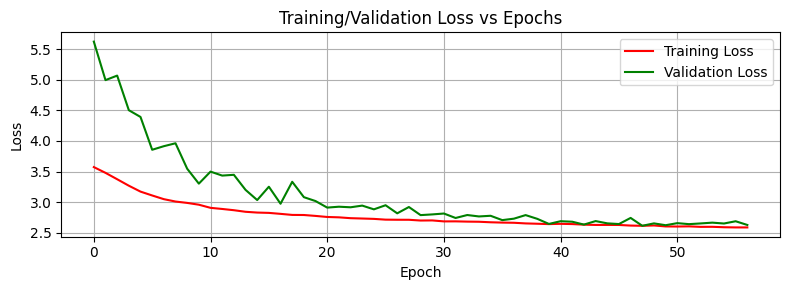


--- Running Final Test Examples ---
Loading best weights from models_pytorch/lipnet_checkpoint.pth for final test...
Best weights loaded successfully.

--- Example Predictions ---
Original:     place green with r seven again
Filtered Idx: [14]
Prediction:   n
--------------------------------------------------
Original:     bin green with u nine again
Filtered Idx: [14]
Prediction:   n
--------------------------------------------------
--- End Examples ---

--- Final Testing Finished ---


In [26]:
# --- Plotting Training/Validation Loss ---
plt.figure(figsize=(8, 3))
# plt.plot(range(1, (EPOCHS - start_epoch) + 1), train_losses, color='red', label="Training Loss")
# plt.plot(range(1, (EPOCHS - start_epoch) + 1), val_losses, color='green', label="Validation Loss")
plt.plot(train_losses, color='red', label="Training Loss")
plt.plot(val_losses, color='green', label="Validation Loss")
plt.title("Training/Validation Loss vs Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve_pytorch.png")
plt.show()

# --- Final Testing Example (similar to TF code) ---
print("\n--- Running Final Test Examples ---")
# Load best weights
if os.path.exists(checkpoint_path):
    print(f"Loading best weights from {checkpoint_path} for final test...")
    try:
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Best weights loaded successfully.")
    except Exception as e:
        print(f"Error loading best weights: {e}")
else:
    print("No checkpoint found for final testing.")

produce_example(model, test_loader, num_to_char_dict) # Show examples with best model
print("--- Final Testing Finished ---")

In [39]:
# import numpy as np
# import glob
# import os

# BASE_PROCESSED_PATH = './processed_mouth_data/'
# FRAME_HEIGHT = 50
# FRAME_WIDTH = 100
# FRAME_CHANNELS = 3
# TARGET_SHAPE_LAST_DIMS = (75, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS)

# print(f"Checking .npy files in {BASE_PROCESSED_PATH}...")
# problem_files = []
# all_files = glob.glob(os.path.join(BASE_PROCESSED_PATH, 's*', '*.npy'))

# if not all_files:
#     print("No .npy files found. Make sure BASE_PROCESSED_PATH is correct.")
# else:
#     print(f"Found {len(all_files)} files. Checking shapes...")
#     for npy_file in all_files:
#         try:
#             data = np.load(npy_file)
#             if data.ndim != 4 or data.shape[:] != TARGET_SHAPE_LAST_DIMS:
#                 print(f"PROBLEM: {npy_file} has shape {data.shape}")
#                 problem_files.append(npy_file)
#         except Exception as e:
#             print(f"ERROR reading {npy_file}: {e}")
#             problem_files.append(npy_file)

#     if not problem_files:
#         print("All checked .npy files seem to have correct H, W, C dimensions.")
#     else:
#         print(f"\nFound {len(problem_files)} files with potential shape issues.")
#         # Optionally, you could delete or reprocess these problem files
#         for f_path in problem_files:
#             os.remove(f_path)
#         print("Problematic files removed. Please re-run preprocessing.")

Checking .npy files in ./processed_mouth_data/...
Found 1000 files. Checking shapes...
PROBLEM: ./processed_mouth_data/s1/lrae3s_mouth.npy has shape (74, 50, 100, 3)
PROBLEM: ./processed_mouth_data/s1/sbbbzp_mouth.npy has shape (74, 50, 100, 3)
PROBLEM: ./processed_mouth_data/s1/srbb4n_mouth.npy has shape (74, 50, 100, 3)
PROBLEM: ./processed_mouth_data/s1/srwi5a_mouth.npy has shape (74, 50, 100, 3)
PROBLEM: ./processed_mouth_data/s1/swao7a_mouth.npy has shape (74, 50, 100, 3)

Found 5 files with potential shape issues.
Problematic files removed. Please re-run preprocessing.
